In [116]:
### GENERAL INFORMATION #######################################################
#   Name:           Gustavo Lelli Guirao                                      #
#   USP number:     11918182                                                  #
#   course code:    SCC0251                                                   #
#   Year/Semestre:  2024/1                                                    #
#   Title:          Assignment 3 : Morphology and Color                       #
###############################################################################

In [117]:
!pip install --upgrade --no-cache-dir gdown matplotlib scikit-image numpy

# Getting the Images

In [118]:
import gdown

# Downloading data from Google Drive
!gdown --id '1j1hB6pOeDPXkolBR4P5VhyYXSauXWmr7' #id do link de compartilhamento (Imagens)

/home/gustavo-lelli/miniconda3/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1j1hB6pOeDPXkolBR4P5VhyYXSauXWmr7
To: /home/gustavo-lelli/Desktop/PI/Assigment 3/Morphology-and-Color/Dataset-AllClasses.zip
100%|██████████████████████████████████████| 2.11M/2.11M [00:00<00:00, 3.36MB/s]


In [119]:
# Unzipping dataset to the root of the notebook

#!unzip /content/Dataset-AllClasses.zip

# Introducing the Input Data

In [120]:
import os
import imageio.v3 as imageio

# Getting input data
dataset_folder = "test_cases_data/"
files = os.listdir(dataset_folder)
files.sort()
print(files)

# Getting reference data
references_folder = "test_cases_references/"
ref_files = os.listdir(references_folder)
ref_files.sort()
print(ref_files)

['chest_xray_1.png', 'chest_xray_2.png', 'chest_xray_3.png', 'chest_xray_4.png', 'chest_xray_5.png', 'chest_xray_6.png', 'skin_lesion_1.jpg', 'skin_lesion_2.jpg', 'skin_lesion_3.jpg', 'skin_lesion_4.jpg', 'skin_lesion_5.jpg', 'skin_lesion_6.jpg']
['chest_xray_1_ref-case1.png', 'chest_xray_2_ref-case2.png', 'chest_xray_3_ref-case3.png', 'chest_xray_4_ref-case4.png', 'chest_xray_5_ref-case5.png', 'chest_xray_6_ref-case6.png', 'skin_lesion_1_ref-case7.png', 'skin_lesion_2_ref-case8.png', 'skin_lesion_3_ref-case9.png', 'skin_lesion_4_ref-case10.png', 'skin_lesion_5_ref-case11.png', 'skin_lesion_6_ref-case12.png']


In [121]:
# Loading images into a list
images = []
for I_file in files:
  I  = imageio.imread(dataset_folder+I_file)
  images.append(I)

In [122]:
import matplotlib.pyplot as plt

def show_images(data, rows=2, columns=5, figsize=(10, 4)):
    fig, axes = plt.subplots(figsize=figsize, nrows=rows, ncols=columns, dpi=150)

    for i in range(rows):
      for j in range(columns):
        ax = axes[i, j]
        idx = i*columns+j
        ax.imshow(data[idx], cmap="gray")
        curr_label = f"Image {idx}"
        ax.title.set_text(curr_label)
        ax.axis('off')
    plt.show()

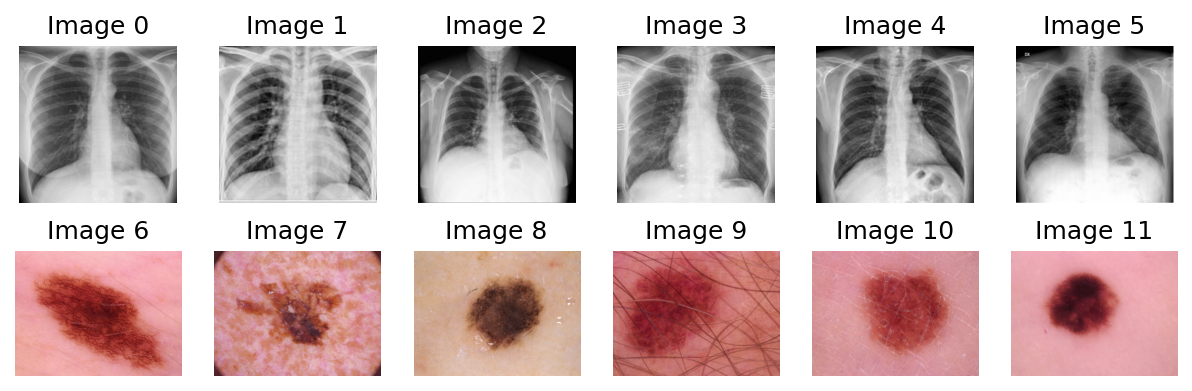

In [123]:
# Showing the input images
show_images(images, rows=2, columns=6, figsize=(10, 3))

# Conversion to Grayscale

In [124]:
import numpy as np

# Converts the images to grayscale
images_gray = []

for img in images:
  if len(img.shape) > 2: # If it is RGB, converts to Gray, otherwise just keeps it
    img = np.dot(img, [0.2989, 0.5870, 0.1140]).astype(np.int64)
  images_gray.append(img)

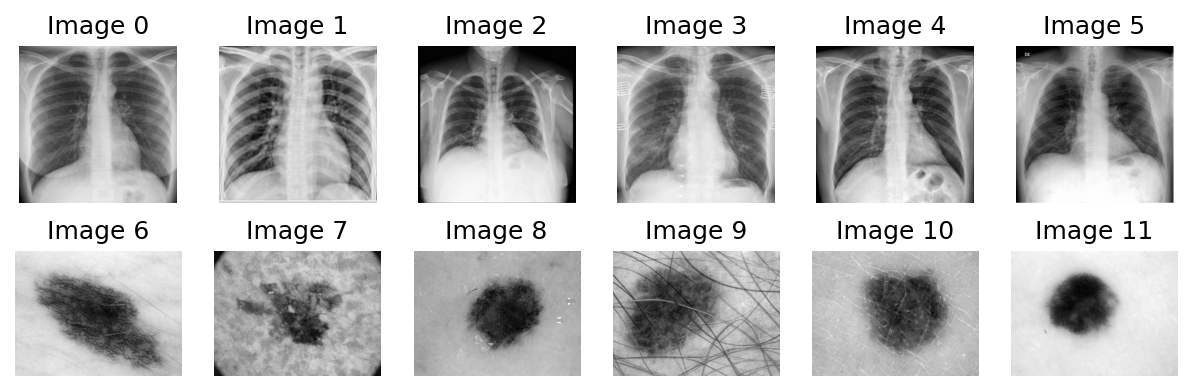

In [125]:
# Showing the input images (In Grayscale)
show_images(images_gray, rows=2, columns=6, figsize=(10, 3))

# Adaptive Thresholding (Otsu)

In [126]:
def otsu(img: np.ndarray, c = 0) -> np.ndarray:
	# Convert the image to grayscale if it is not already
	if len(img.shape) == 3:
		img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

	# Calculate histogram
	hist, bins = np.histogram(img.flatten(), 256, [0,256])

	# Total number of pixels
	total = img.size

	current_max, threshold = 0, 0
	sumT, sumF, sumB = 0, 0, 0
	weightB, weightF = 0, 0

	for i in range(256):
		sumT += i * hist[i]

	for i in range(256):
		weightB += hist[i]
		if weightB == 0:
			continue
		weightF = total - weightB
		if weightF == 0:
			break

		sumB += i * hist[i]
		sumF = sumT - sumB

		meanB = sumB / weightB
		meanF = sumF / weightF

		# Calculate Between Class Variance
		varBetween = weightB * weightF
		varBetween *= (meanB - meanF) ** 2

		# Check if new maximum found
		if varBetween > current_max:
			current_max = varBetween
			threshold = i

	# Apply threshold to image
	binary_mask = img.copy()
	binary_mask[img > threshold] = 255
	binary_mask[img <= threshold] = 0

	return binary_mask

In [127]:
# Converts the images to binary
images_bin = []

for img in images_gray:
  new_img = otsu(img.copy(), c = 0)
  images_bin.append(new_img)

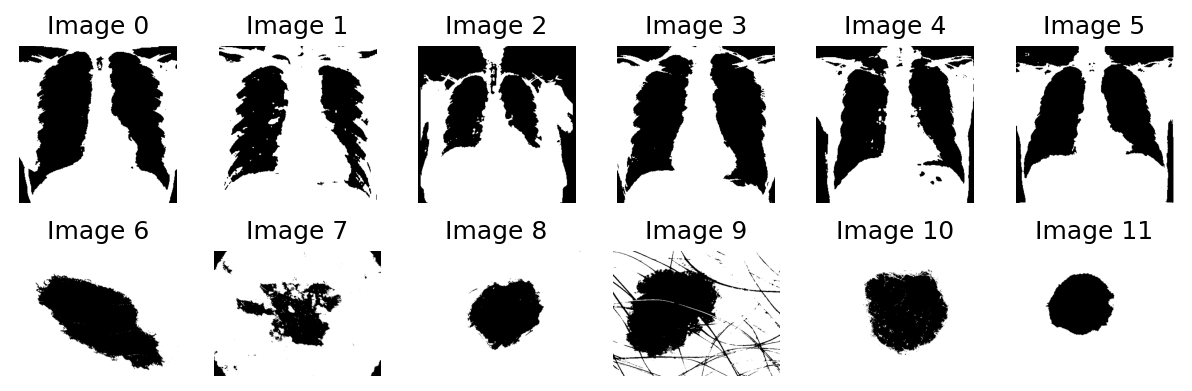

In [128]:
# Showing the input images (In Grayscale)
show_images(images_bin, rows=2, columns=6, figsize=(10, 3))
import math

"""Calcula o erro"""
# Root Mean Squared Error
def RMSE(reference_image, filtered_image):
    result = 0
    n, m = filtered_image.shape

    for i in range(n):
        for j in range(m):
            result += ((reference_image[i][j] - filtered_image[i][j]) ** 2)
    rmse = math.sqrt(result / (n * m))
    
    return rmse

# Applying Morphological Processing (Erosion and Dilation)

In [129]:
def erosion(img, M, N):
	kernel_size = 3
	# Pad the image with zeros around the border
	padded_img = np.pad(img, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2)), mode='constant')

	# Initialize an empty output image
	output_img = np.ones_like(img)

	# Apply the erosion operation
	for i in range(M):
		for j in range(N):
			# Extract the region of interest
			region = padded_img[i:i+kernel_size, j:j+kernel_size]
			
			# The output pixel is the minimum value in the region
			output_img[i, j] = np.min(region)

	return output_img.astype(np.uint8)

def dilation(img, M, N):
	kernel_size = 3
	# Pad the image with zeros around the border
	padded_img = np.pad(img, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2)), mode='constant')

	# Initialize an empty output image
	output_img = np.ones_like(img)

	# Apply the dilation operation
	for i in range(M):
		for j in range(N):
			# Extract the region of interest
			region = padded_img[i:i+kernel_size, j:j+kernel_size]

			# The output pixel is the maximum value in the region
			output_img[i, j] = np.max(region)

	return output_img.astype(np.uint8)

In [130]:
# Define the set of operations to be performed for each image individually
# 1=erosion, 2=dilation
ciclo_morfologico = [[2,2,2,2,2,2,2,2,2,1,1,1], #Image 0
                     [1,1,1,2,2,2,2,1], #Image 1
                     [2,2,2,2,1], #Image 2
                     [2,2,1,1], #Image 3
                     [2,2,1,1,2,2,1], #Image 4
                     [2,2,2,2,2,2,1,1,1], #Image 5
                     [1,1,2,2,1], #Image 6
                     [1,1,1,1,1,1,1,2,2,2,2,2,2,2], #Image 7
                     [1,1,2,2,2], #Image 8
                     [2,2,2,2,1,1,1,1,1], #Image 9
                     [1,1,2,2], #Image 10
                     [1,1,2,2]] #Image 11

# Apply Morphological Operations
images_morf = []
for idx,img in enumerate(images_bin):
	M,N = img.shape
	for apply_morphology in ciclo_morfologico[idx]:
		if apply_morphology == 1:
			# Cycle of Erosions (Expands the area of BLACK interest and Reduces WHITE -> Return to the original size without noise)
			img = erosion(img, M, N)
		elif apply_morphology == 2:
			# Cycle of Dilations (Expands the area of WHITE non-interest and Reduces BLACK -> Noise Reduction)
			img = dilation(img, M, N)
	images_morf.append(img)

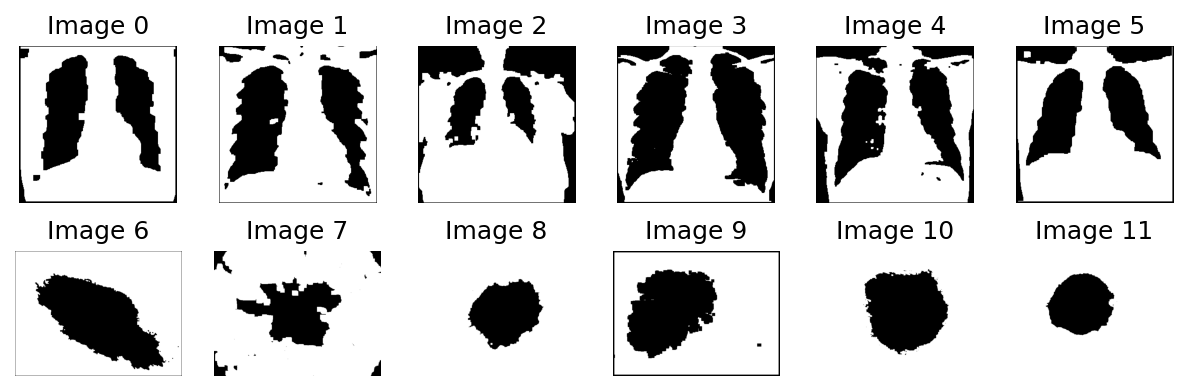

In [131]:
# Showing the input images (In Grayscale)
show_images(images_morf, rows=2, columns=6, figsize=(10, 3))

# Applying Color in Regions of Interest (Heatmap)

In [132]:
def filter_gaussian(P, Q):
    s1 = P
    s2 = Q

    D = np.zeros([P, Q])  # Compute Distances
    for u in range(P):
        for v in range(Q):
            x = (u-(P/2))**2/(2*s1**2) + (v-(Q/2))**2/(2*s2**2)
            D[u, v] = np.exp(-x)
    return D

In [133]:
# Visible Spectrum
heatmap_colors = [
    [1, 0, 1],   # Pink
    [0, 0, 1],   # Blue
    [0, 1, 0],   # Green
    [1, 1, 0],   # Yellow
    [1, 0, 0]    # Red
]

# Function to map values to colors
def map_value_to_color(value, min_val, max_val, colormap):
    # Scale the value to the range [0, len(colormap) - 1]
    scaled_value = (value - min_val) / (max_val - min_val) * (len(colormap) - 1)
    # Determine the two closest colors in the colormap
    idx1 = int(scaled_value)
    idx2 = min(idx1 + 1, len(colormap) - 1)
    # Interpolate between the two colors based on the fractional part
    frac = scaled_value - idx1
    color = [
        (1 - frac) * colormap[idx1][0] + frac * colormap[idx2][0],
        (1 - frac) * colormap[idx1][1] + frac * colormap[idx2][1],
        (1 - frac) * colormap[idx1][2] + frac * colormap[idx2][2]
    ]
    return color

In [134]:
import math

"""Calcula o erro"""
# Root Mean Squared Error
def RMSE(reference_image, filtered_image):
    result = 0
    n, m = filtered_image.shape

    for i in range(n):
        for j in range(m):
            result += ((reference_image[i][j] - filtered_image[i][j]) ** 2)
    rmse = math.sqrt(result / (n * m))
    
    return rmse

In [135]:
images_out = []

# Define alpha value for blending
alpha = 0.30  # Adjust this value to control the transparency of the heatmap

ref = 0
for idx,img in enumerate(images_gray):
  # Getting the binary mask
  mask = images_morf[idx]

  # Color Gradient
  M, N = mask.shape[0], mask.shape[1]
  color_distribution = filter_gaussian(M, N)
  min_val = np.min(np.array(color_distribution))
  max_val = np.max(np.array(color_distribution))

  heatmap_image = np.zeros([M, N, 3]) # empty RGB image
  for i in range(M):
      for j in range(N):
          heatmap_image[i, j] = map_value_to_color(color_distribution[i, j], min_val, max_val, heatmap_colors)

  img_color = np.ones([M, N, 3]) # empty RGB image
  indexes = np.where(mask==0)
  img_color[indexes] = heatmap_image[indexes]

  # Final image
  gray_image = img
  gray_image_normalized = gray_image / np.max(gray_image)

  # Mix the grayscale image and heatmap using alpha compositing
  #mixed_image = ((1 - alpha) * gray_image_normalized) + (alpha * heatmap_image)

  # Expand dimensions of the grayscale image to make it a 3D array
  gray_image_normalized_3d = np.expand_dims(gray_image_normalized, axis=-1)
  
  # Now you can add them together
  mixed_image = ((1.0 - alpha) * gray_image_normalized_3d) + (alpha * img_color)

  images_out.append(mixed_image)

  # Calculate the error for each color channel
  H  = imageio.imread("test_cases_references/" + ref_files[ref]) # Load the Reference Image
  error_R = RMSE(H[:,:,0], mixed_image[:,:,0],)
  error_G = RMSE(H[:,:,1], mixed_image[:,:,1])
  error_B = RMSE(H[:,:,2], mixed_image[:,:,2])
  error = (error_R + error_G + error_B)/3
  print(f"{error:.4f}")
  ref+=1

172.2893
190.8687
172.0337
175.8978
166.2689
175.1329
198.4103
188.3780
187.8697
185.5571
196.7036
221.5994


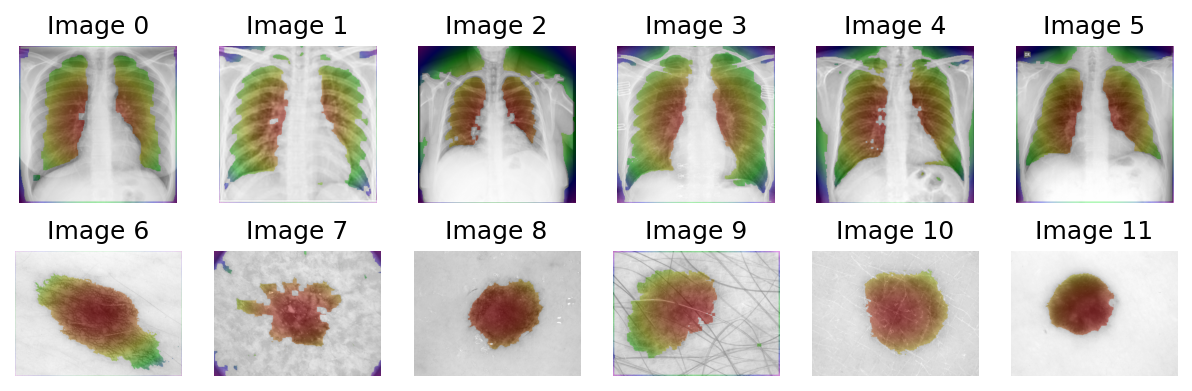

In [136]:
# Showing the input images (In Grayscale)
show_images(images_out, rows=2, columns=6, figsize=(10, 3))